In [5]:
#!pip install yfinance

Getting stocks data using yfinance library

In [1]:
import yfinance as yf
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [2]:
data = yf.Ticker("TSLA")
hist = data.history(period="max")
hist.to_csv('tsla.csv')
data = pd.read_csv('tsla.csv')
data['Date'] = pd.to_datetime(data['Date'])

In [3]:
data.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
2931,2022-02-17,913.260010,918.500000,874.099976,876.349976,18392800,0,0.0
2932,2022-02-18,886.000000,886.869995,837.609985,856.979980,22710500,0,0.0
2933,2022-02-22,834.130005,856.729980,801.099976,821.530029,27762700,0,0.0
2934,2022-02-23,830.429993,835.299988,760.559998,764.039978,31752300,0,0.0
2935,2022-02-24,700.390015,802.479980,700.000000,800.770020,44854362,0,0.0


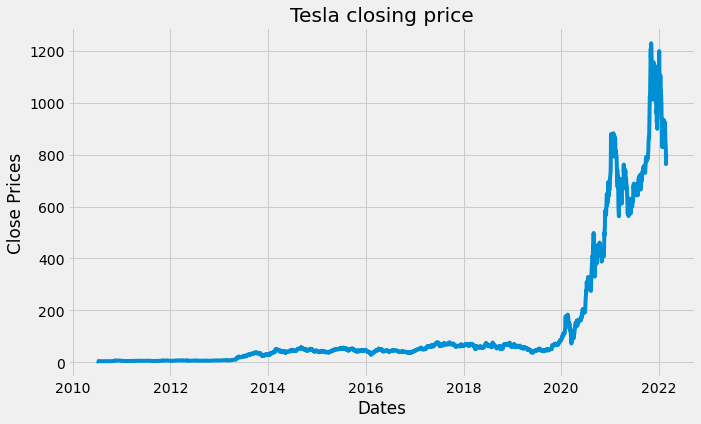

In [4]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Date'],data['Close'])
plt.title('Tesla closing price')
plt.show()

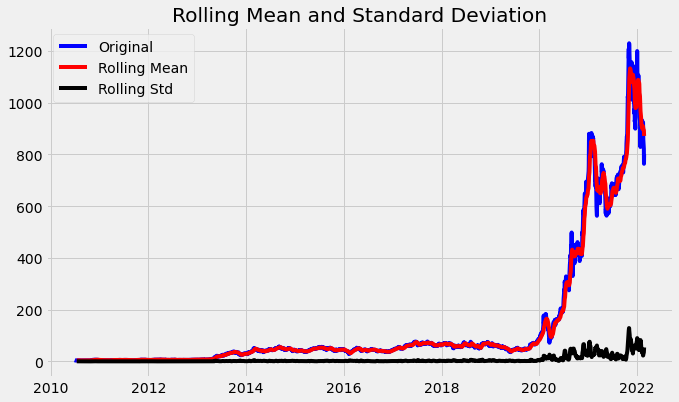

Results of dickey fuller test
Test Statistics                   0.198314
p-value                           0.972167
No. of lags used                 28.000000
Number of observations used    2907.000000
critical value (1%)              -3.432601
critical value (5%)              -2.862535
critical value (10%)             -2.567300
dtype: float64


In [6]:
#Test for staionarity
df_close = data['Close']
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(data['Date'],timeseries, color='blue',label='Original')
    plt.plot(data['Date'],rolmean, color='red', label='Rolling Mean')
    plt.plot(data['Date'],rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

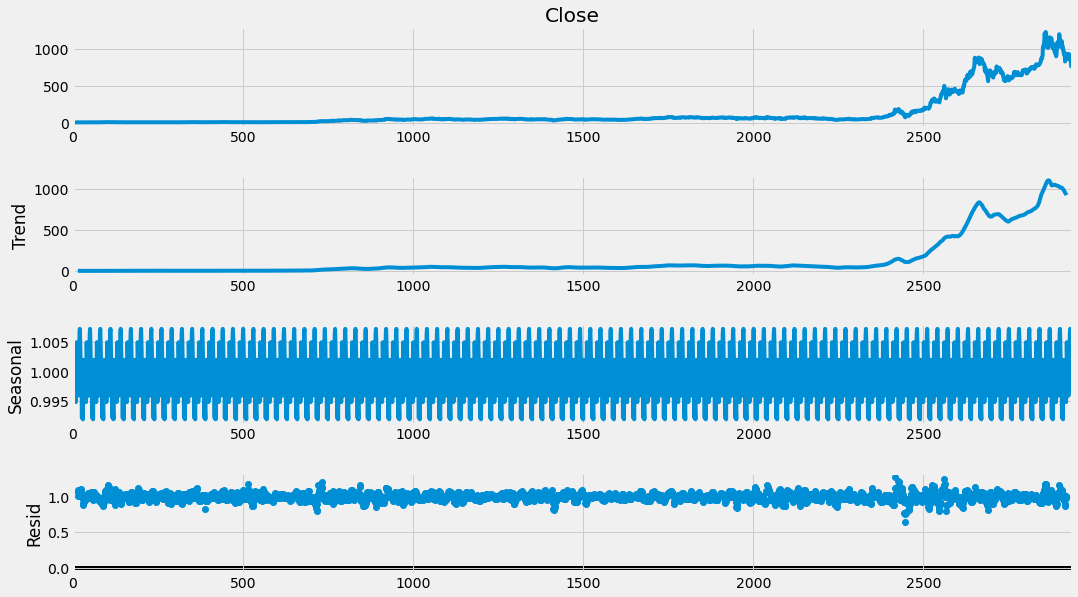

In [7]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


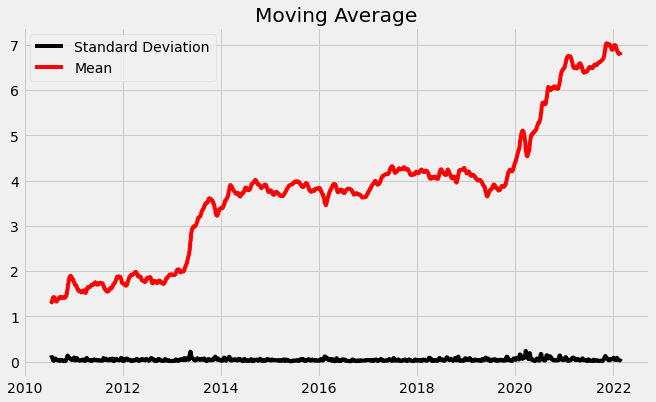

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
dates = data['Date']
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(dates,std_dev, color ="black", label = "Standard Deviation")
plt.plot(dates,moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [9]:
type(df_log)

pandas.core.series.Series

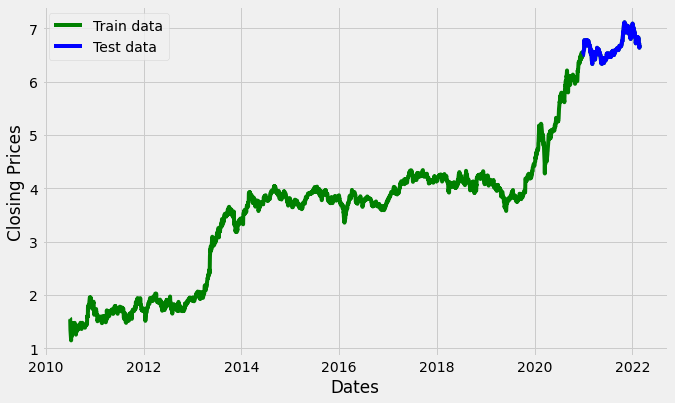

In [10]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
train_data_dates, test_data_dates = dates[3:int(len(dates)*0.9)], dates[int(len(dates)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(dates,df_log, 'green', label='Train data')
plt.plot(test_data_dates,test_data, 'blue', label='Test data')
plt.legend()

In [11]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10163.124, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10161.148, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10161.147, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10157.111, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10159.124, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.352 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2639
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5083.562
Date:                Fri, 25 Feb 2022   AIC                         -10163.124
Time:                        02:02:32   BIC                         -10151.368
Sample:                             0   HQIC                        -10158.868
                               - 2639                             

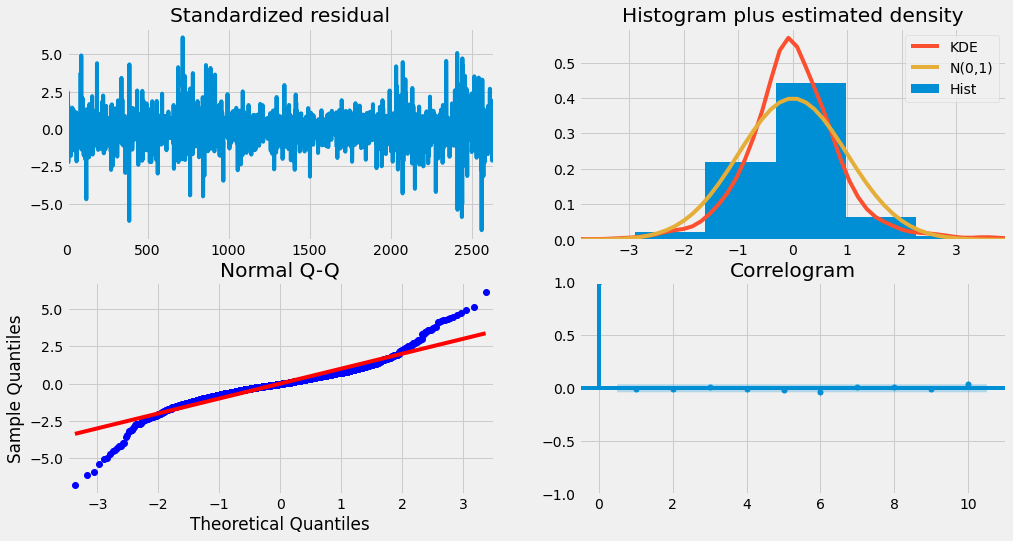

In [12]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [13]:
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2638
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5083.562
Method:                           css   S.D. of innovations              0.035
Date:                Fri, 25 Feb 2022   AIC                         -10163.124
Time:                        02:03:10   BIC                         -10151.368
Sample:                             1   HQIC                        -10158.868
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.833      0.005       0.001       0.003


In [27]:
# Forecast
import plotly.express as px
import plotly.graph_objects as go
fc, se, conf = fitted.forecast(294, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_dates, y=train_data, name="Training"))
fig.add_trace(go.Scatter(x=test_data_dates, y=test_data, name="Actual Stock Price"))
fig.add_trace(go.Scatter(x=test_data_dates, y=fc_series, name="Predicted Stock Price"))
fig.update_layout(
    title="Tesla Stock Prediction with ARIMA",
    xaxis_title="Dates",
    yaxis_title="Log of Prices"
)
fig.show()

<Figure size 1200x500 with 0 Axes>

In [67]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.034831183757397396
MAE: 0.16299723452945755
RMSE: 0.1866311435891593
MAPE: 0.024650499795691526
